In [14]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_concurrency_parallelism(cc_value):
    value = int(sqrt(cc_value))
    return value, value

def process_log_files(directory):
    dataframes = []
    for filename in os.listdir(directory):
        if filename.startswith("GD_") and filename.endswith(".log"):
            full_path = os.path.join(directory, filename)
            with open(full_path, 'r') as file:
                data = []
                last_non_zero_throughput = None
                for line in file:
                    match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+) CC:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:(\d+\.\d+)', line)
                    if match:
                        time = datetime.fromtimestamp(float(match.group(1)))
                        throughput = float(match.group(3))
                        if throughput == 0.00 and last_non_zero_throughput is not None:
                            throughput = last_non_zero_throughput
                        elif throughput != 0.00:
                            last_non_zero_throughput = throughput

                        loss_rate = float(match.group(4))
                        cc = int(match.group(5))
                        score = float(match.group(6))
                        rtt = float(match.group(7))
                        energy = float(match.group(8))
                        sender_lr = float(match.group(9))
                        concurrency, parallelism = get_concurrency_parallelism(cc)
                        data.append([time, throughput, loss_rate, cc, score, rtt, energy, sender_lr, concurrency, parallelism])

                df = pd.DataFrame(data, columns=['Time', 'Throughput', 'receiver_lr', 'CC', 'Score', 'RTT', 'Energy', 'sender_lr', 'concurrency', 'parallelism'])
                # Fill in zero throughput with the previous non-zero value
                df['Throughput'] = df['Throughput'].replace(0, np.nan)
                df['Throughput'].fillna(method='ffill', inplace=True)
                dataframes.append(df)
    return dataframes



                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-18 22:10:23.986467         NaN          0.0   1   -0.0   0.0   
1   2023-12-18 22:10:24.983981         NaN          0.0   1   -0.0   0.0   
2   2023-12-18 22:10:25.985396         NaN          0.0   1   -0.0  32.6   
3   2023-12-18 22:10:26.987168         NaN          0.0   1   -0.0  32.6   
4   2023-12-18 22:10:27.987139         NaN          0.0   1   -0.0  32.6   
..                         ...         ...          ...  ..    ...   ...   
97  2023-12-18 22:12:01.087025        0.96          0.0  36   -0.0  32.7   
98  2023-12-18 22:12:02.088151        0.96          0.0  36   -0.0  32.7   
99  2023-12-18 22:12:03.089911        0.96          0.0  36   -0.0  32.7   
100 2023-12-18 22:12:04.090889        0.96          0.0  36   -0.0  32.6   
101 2023-12-18 22:12:05.091314        0.96          0.0  36   -0.0  32.6   

     Energy  sender_lr  concurrency  parallelism  
0       0.0        0.0            1 

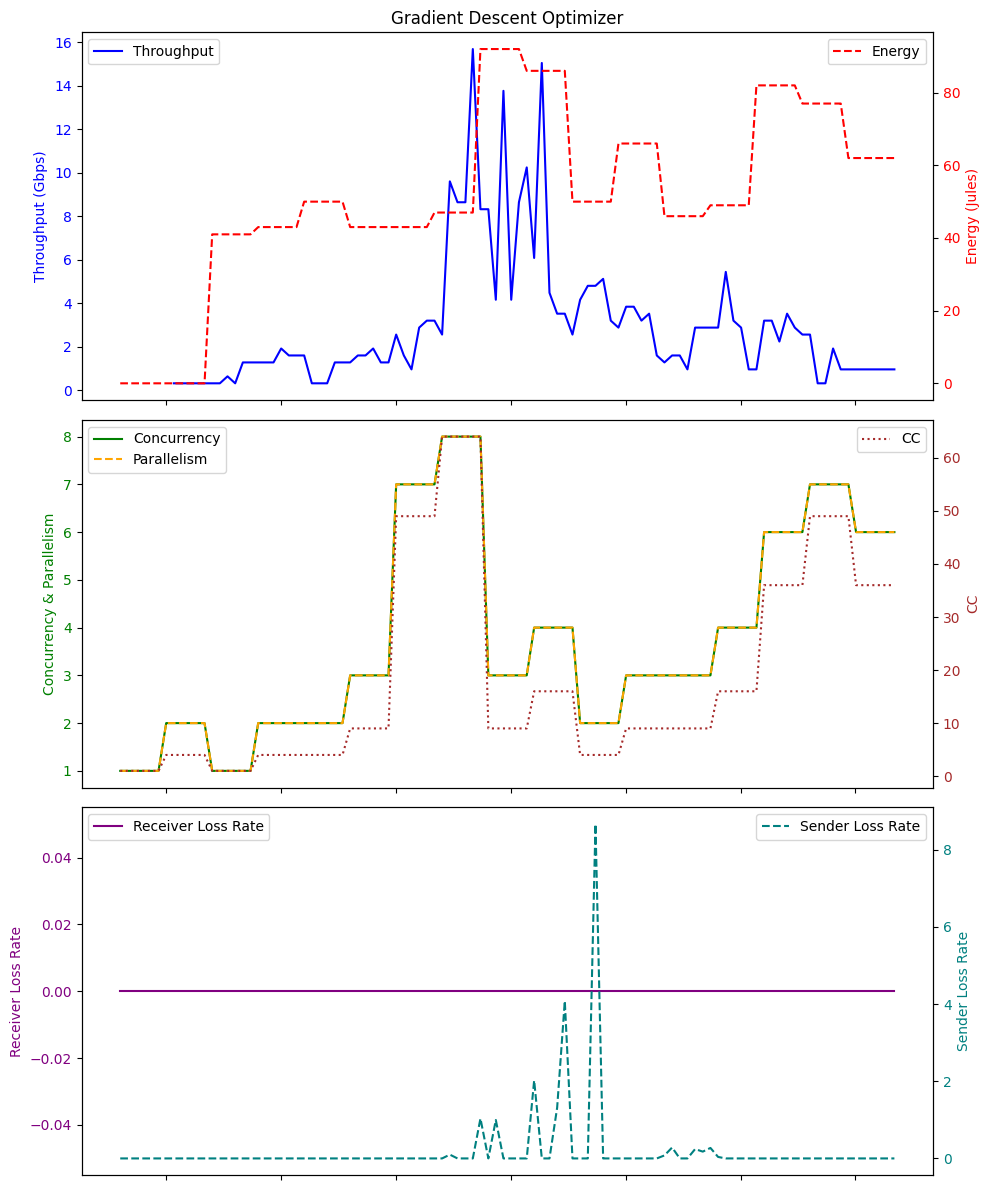

In [21]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory)

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Gradient Descent Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')


    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.show()